# Linear Market Runs Analysis 

### Preparation of LR

- Import libraris
- Prepare data (convert tick data to seconds/minute interval time-series)
- Reduce size of datasets
- Isolate linear runs from several different days (LR)
- Visualise LR

In [2]:
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
pd.set_option('display.max_columns', None)

### Set 1

In [3]:
es = pd.read_csv("C:\August2022\ES 12-22 Globex_2022_09_19.csv", index_col= 0, parse_dates=True )
mapping = {'AtBid': -1, 'AtAsk': 1, 'BelowBid': -2, 'AboveAsk': 2, 'BetweenBidAsk':0 }   # remap categorical ---->  ints 
es = es.replace({'AtAsk': mapping})
es.rename(columns={'1': 'Vol', 'AtAsk':'BidAsk', '3882.1':'Price' }, inplace=True)
del es['3881.75']  # deleting not needed columns
del es['3882']
es.index.name = 'DateTime' 
es['Date'] = es.index # make separate dateTime column
es.head()

,Vol,BidAsk,Price,Date
DateTime,,,,
2022-09-19 00:00:02,1,1,3882.25,2022-09-19 00:00:02
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03


- Resampling functions for time regularization of tick dataset (with repeating ticks) to second-interval (non-repeating) timeseries

In [80]:
def resample_df(df, col1, name1, col2, name2, col3, name3, on_col, on_name):
    df = pd.DataFrame({name1: col1, on_col: on_col})
    res_df = df.resample('1s', on= on_name).sum()
    return res_df

def resampling_sum(col1, name1, on_col, on_name):  
    '''make resampled df from columns on max; change to '1Min' if minutes needed'''
    df = pd.DataFrame({name1: col1, on_name: on_col})
    res_df = df.resample('1s', on= on_name).sum() #.fillna(0)
    return res_df

def resampling_max(col1, name1, on_col, on_name):
    '''make resampled df from columns on max; change to '1Min' if minutes needed'''
    df = pd.DataFrame({name1: col1, on_name: on_col})
    res_df = df.resample('1s', on= on_name).max() #.fillna(0)
    return res_df

def merge_resampled_DFs(d1, d2, d3):
    d = pd.DataFrame()
    d = pd.merge(d1, d2, on='Date')
    d = pd.merge(d, d3, on='Date')
    return d

def resampling_cum(col1, name1, on_col, on_name):  
    '''make resampled df from columns on max; change to '1Min' if minutes needed'''
    df = pd.DataFrame({name1: col1, on_name: on_col})
    res_df = df.resample('1s', on= on_name).sum() #.fillna(0)
    res_df1 = res_df.cumsum()
    return res_df1


In [42]:
es.head(10)

,Vol,BidAsk,Price,Date
DateTime,,,,
2022-09-19 00:00:02,1,1,3882.25,2022-09-19 00:00:02
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:03,1,-1,3882.00,2022-09-19 00:00:03
2022-09-19 00:00:04,1,1,3882.00,2022-09-19 00:00:04
2022-09-19 00:00:05,1,1,3882.25,2022-09-19 00:00:05


In [118]:
aa = resampling_sum(es['Vol'], 'Vol', es.Date, 'Date')  # from column Vol
aa.shape  # (86394, 1)
aa.head(10)

bb = resampling_sum(es['BidAsk'], 'BidAsk',  es.Date, 'Date')  # from column BidAsk
bb.shape  # (86394, 1)
bb.head(10)

bbCum = resampling_cum(es['BidAsk'], 'BidAsk',  es.Date, 'Date')  # from column BidAsk cummulative 
bbCum.shape  # (86394, 1)
bbCum.tail(10)

cc = resampling_max(es['Price'], 'Price',  es.Date, 'Date') # from column Price 
cc.shape  # (86394, 1)
cc.index.name = 'Date' 
del cc['Date']
cc.sample(4)

fff = merge_resampled_DFs(aa, bb, cc)   # merge resampled frames 
fff.shape  # (86394, 3)
fff1 = pd.merge(fff, bbCum, on='Date') # merge resampled frames 
fff1.head()
cols = ['Vol', 'BidAsk', 'Price', 'BidAskCum']   # rename resampled frames 
fff1.columns = cols
fff1.tail()
fff1.shape   #(86394, 4)
type(fff1.index)# pandas.core.indexes.datetimes.DatetimeIndex
fff2 = fff1.copy()
fff2.dropna(inplace=True)
fff2.shape  # (49429, 4)
fff2.sample(5)

,Vol,BidAsk,Price,BidAskCum
Date,,,,
2022-09-19 16:01:12,97,6,3921.25,1475
2022-09-19 11:00:09,24,6,3895.00,2930
2022-09-19 21:42:24,2,-2,3920.75,1722
2022-09-19 08:41:02,124,-21,3862.25,-1277
2022-09-19 22:51:34,1,1,3923.50,1926


- Reduced set from 1.5M to ~ 49429 ~  0.97% 

In [282]:
49429 / 1500000 # 0.033
1 - 0.033 #  0.97% 

0.967

In [119]:
fff2.head(5)

,Vol,BidAsk,Price,BidAskCum
Date,,,,
2022-09-19 00:00:02,1,1,3882.25,1
2022-09-19 00:00:03,6,-6,3882.00,-5
2022-09-19 00:00:04,1,1,3882.00,-4
2022-09-19 00:00:05,1,1,3882.25,-3
2022-09-19 00:00:15,1,1,3882.00,-2


In [211]:
type(fff2.index)

pandas.core.indexes.datetimes.DatetimeIndex

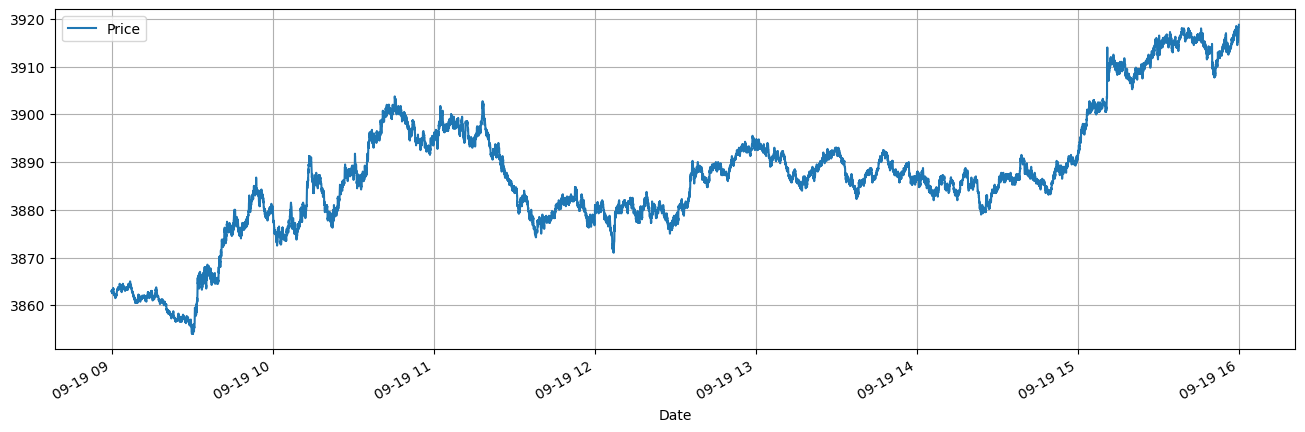

In [120]:
fff2['2022-09-19 09:00:00': '2022-09-19 16:00:00'].plot(y = 'Price', figsize=(16,5))  
plt.grid()  

In [130]:
fff2.to_csv('ES2022-09-19Sec.csv')

### We will isolate 20 min of clear LR at for further analysis

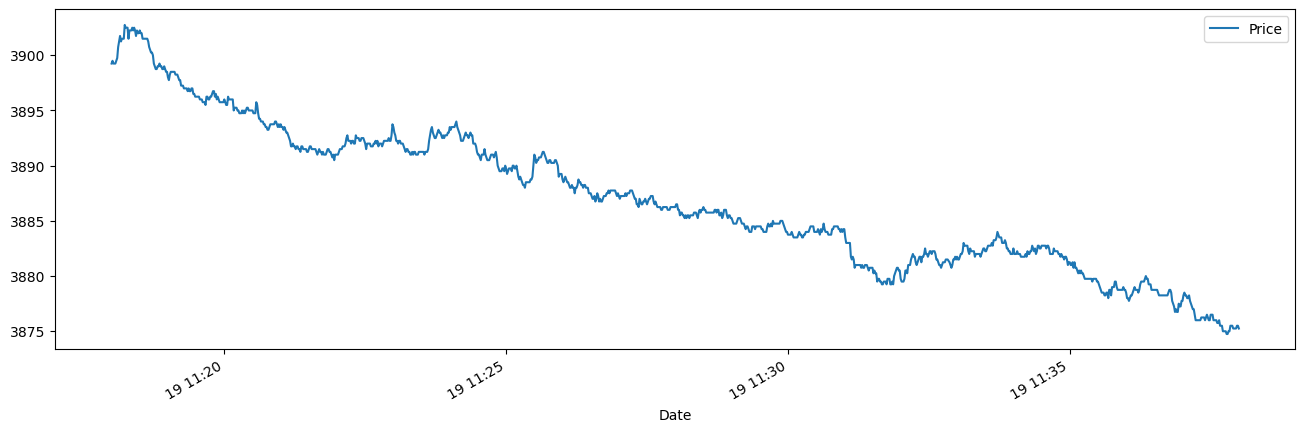

In [133]:
lr1 = fff2['2022-09-19 11:18:00': '2022-09-19 11:38:00']
lr1.plot(y = 'Price', figsize=(16,5))  
lr1.to_csv('ES2022-09-19SecLR1.csv')

#### Set 2

In [175]:
d = r"C:\BidAskRepo\ES 03-23 Globex_2022_12_23.csv"
es2 = pd.read_csv(d, index_col= 0, parse_dates=True )
mapping = {'AtBid': -1, 'AtAsk': 1, 'BelowBid': -2, 'AboveAsk': 2, 'BetweenBidAsk':0 }   # remap categorical ---->  ints 
es2 = es2.replace({'AtAsk': mapping})
es2.rename(columns={'1': 'Vol', 'AtAsk':'BidAsk', '3882.1':'Price' }, inplace=True)
del es2['3853.25']
es2.index.name = 'DateTime' 
es2['Date'] = es2.index # make separate dateTime column
es2.rename(columns={'3853.25.1': 'Price'}, inplace=True)
es2.shape  # (1365444, 4)
es2.head()

,Vol,BidAsk,Price,Date
DateTime,,,,
2022-12-23,1,-1,3853.0,2022-12-23
2022-12-23,1,-1,3853.0,2022-12-23
2022-12-23,2,-1,3853.0,2022-12-23
2022-12-23,1,-1,3853.0,2022-12-23
2022-12-23,1,-1,3853.0,2022-12-23


In [208]:
aa2 = resampling_sum(es2['Vol'], 'Vol', es2.Date, 'Date')  # from column Vol
aa2.shape  # (61200, 1)
aa2.head(10)

bb2 = resampling_sum(es2['BidAsk'], 'BidAsk',  es2.Date, 'Date')  # from column BidAsk
bb2.shape  # (61200, 1)
bb2.head(10)

bbCum2 = resampling_cum(es2['BidAsk'], 'BidAsk',  es2.Date, 'Date')  # from column BidAsk cummulative 
bbCum2.shape  # (61200, 1)
bbCum2.tail(10)

cc2 = resampling_max(es2['Price'], 'Price',  es2.Date, 'Date') # from column Price 
cc2.shape  #  (61200, 1)
cc2.index.name = 'Date' 
del cc2['Date']
cc2.sample(4)

merged2 = merge_resampled_DFs(aa2, bb2, cc2)   # merge resampled frames 
merged2.shape  # (61200, 3)
mergedAgain = pd.merge(merged2, bbCum2, on='Date') # merge resampled frames 
mergedAgain.head()

cols = ['Vol', 'BidAsk', 'Price', 'BidAskCum']   # rename resampled frames 
mergedAgain.columns = cols
mergedAgain.tail()
mergedAgain.shape   # (61200, 4)
type(mergedAgain.index)# pandas.core.indexes.datetimes.DatetimeIndex
df2 = mergedAgain.copy()
df2.dropna(inplace=True)
df2.shape  # (38028, 4)
type(df2.index)
df2.head(5)

,Vol,BidAsk,Price,BidAskCum
Date,,,,
2022-12-23 00:00:00,11,0,3853.25,0
2022-12-23 00:00:04,2,2,3853.00,2
2022-12-23 00:00:07,10,2,3853.00,4
2022-12-23 00:00:09,1,1,3853.00,5
2022-12-23 00:00:13,2,2,3853.00,7


In [230]:
df2.to_csv('ES2022-12-23Sec.csv')

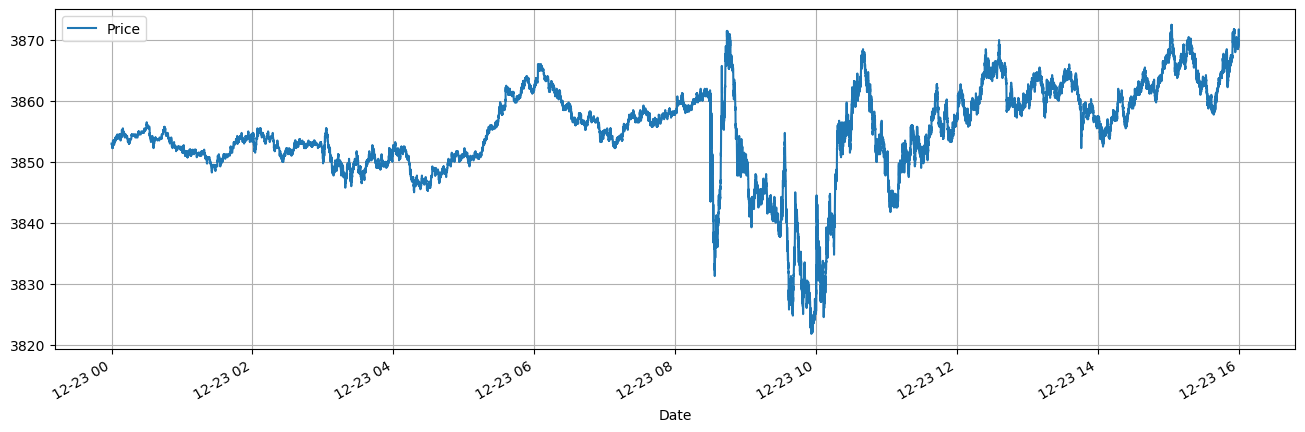

In [216]:
df2['2022-12-23 00:00:04': '2022-12-23 16:00:04'].plot(y = 'Price', figsize=(16,5))   # Entire day set
plt.grid()  

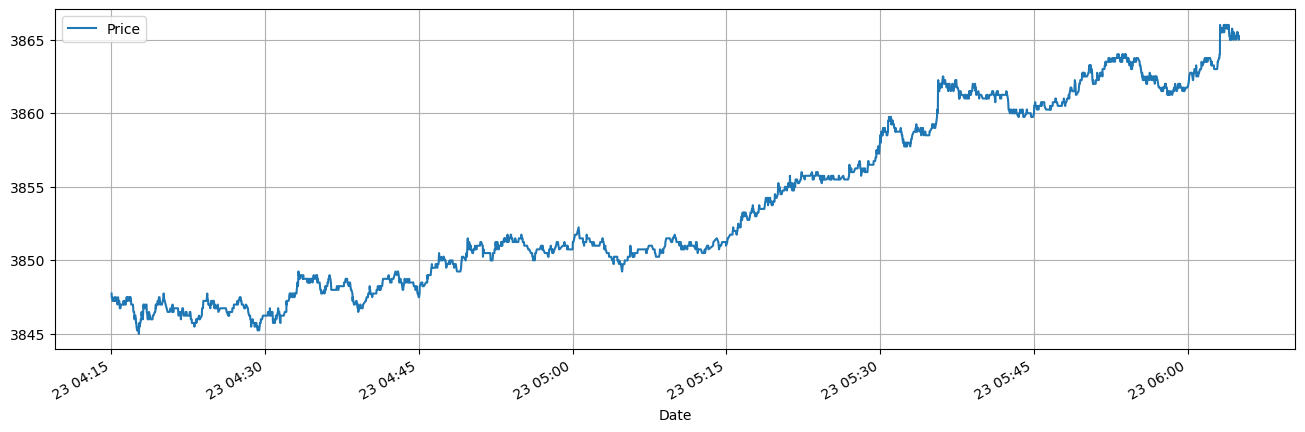

In [225]:
lr2 = df2['2022-12-23 04:15:00': '2022-12-23 06:05:00'].plot(y = 'Price', figsize=(16,5))  
plt.grid()  


In [ ]:
lr2 = df2['2022-12-23 04:15:00': '2022-12-23 06:05:00'].copy()
lr2.shape # (2533, 4)
lr2.to_csv('ES2022-12-23SecLR2.csv')

### Set 3

In [247]:
d1 = "C:\BidAskRepo\ES 12-22 Globex_2022_10_03.csv"
es3 = pd.read_csv(d1, index_col= 0, parse_dates=True )
mapping = {'AtBid': -1, 'AtAsk': 1, 'BelowBid': -2, 'AboveAsk': 2, 'BetweenBidAsk':0 }   # remap categorical ---->  ints 
es3 = es3.replace({'AtAsk': mapping})
es3.rename(columns={'1': 'Vol', 'AtAsk':'BidAsk', '3882.1':'Price' }, inplace=True)
es3.index.name = 'DateTime' 
es3['Date'] = es3.index # make separate dateTime column
del es3['3599.5']
es3.rename(columns={'3599.5.1': 'Price'}, inplace=True)
es3.head()
# es3.dtypes
# type(es3.index)   # pandas.core.indexes.datetimes.DatetimeIndex

,Vol,BidAsk,3599.25,Price,Date
DateTime,,,,,
2022-10-03 00:00:03,1,1,3599.25,3599.5,2022-10-03 00:00:03
2022-10-03 00:00:03,1,1,3599.25,3599.5,2022-10-03 00:00:03
2022-10-03 00:00:03,1,1,3599.25,3599.5,2022-10-03 00:00:03
2022-10-03 00:00:03,1,1,3599.25,3599.5,2022-10-03 00:00:03
2022-10-03 00:00:05,1,-1,3599.50,3599.5,2022-10-03 00:00:05


In [270]:
aa3 = resampling_sum(es3['Vol'], 'Vol', es3.Date, 'Date')  # from column Vol
# aa3.shape  # (86394, 1)
aa3.head(10)

bb3 = resampling_sum(es3['BidAsk'], 'BidAsk',  es3.Date, 'Date')  # from column BidAsk
bb3.shape  # (86394, 1)
bb3.head(10)

bbCum3 = resampling_cum(es3['BidAsk'], 'BidAsk',  es3.Date, 'Date')  # from column BidAsk cummulative 
bbCum3.shape  # (86394, 1)
bbCum3.tail(10)

cc3 = resampling_max(es3['Price'], 'Price',  es3.Date, 'Date') # from column Price 
cc3.shape  # (86394, 1)
cc3.index.name = 'Date' 
del cc3['Date']
cc3.sample(4)

df3 = merge_resampled_DFs(aa3, bb3, cc3)   # merge resampled frames 
df3.shape  # (86394, 3)
df3 = pd.merge(df3, bbCum3, on='Date') # merge resampled frames 
df3.head()
cols = ['Vol', 'BidAsk', 'Price', 'BidAskCum']   # rename resampled frames 
df3.columns = cols
df3.tail()
df3.shape   #(86394, 4)
type(df3.index)# pandas.core.indexes.datetimes.DatetimeIndex
dff3 = df3.copy()
dff3.dropna(inplace=True)
dff3.shape  # (58403, 4)
dff3.sample(5)


,Vol,BidAsk,Price,BidAskCum
Date,,,,
2022-10-03 14:26:49,15,3,3695.00,19458
2022-10-03 21:24:15,1,-1,3710.00,22316
2022-10-03 14:00:53,12,11,3684.00,16322
2022-10-03 01:20:16,4,2,3590.25,-1190
2022-10-03 18:48:07,5,-5,3690.50,20504


In [272]:
dff3.to_csv('ES2022-10-03Sec.csv')

<AxesSubplot: xlabel='Date'>

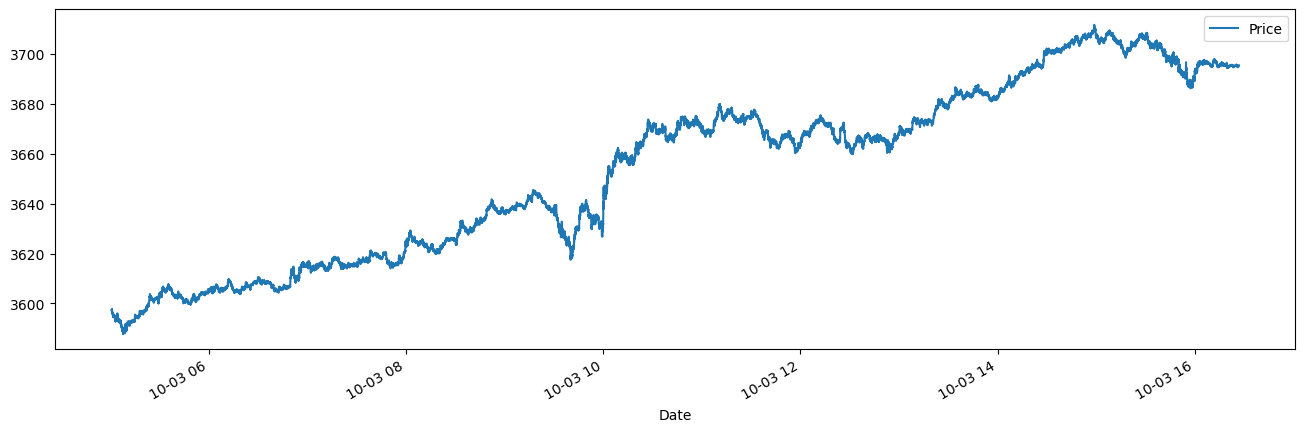

In [271]:
dff3['2022-10-03 05:00:49': '2022-10-03 16:26:49'].plot(y = 'Price', figsize=(16,5))  

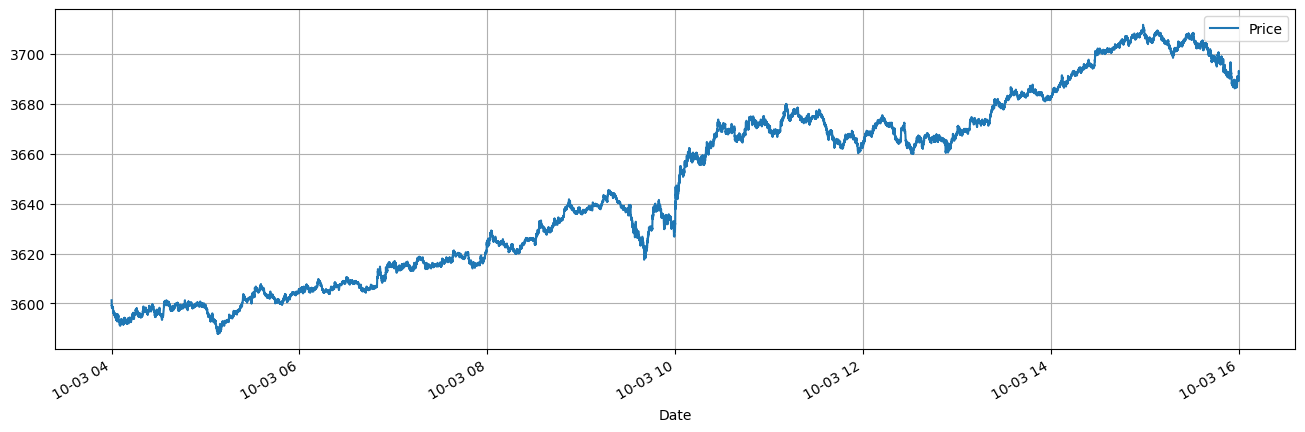

In [275]:
lr3 = dff3['2022-10-03 04:00:00': '2022-10-03 16:00:00']
lr3.plot(y = 'Price', figsize=(16,5))  
plt.grid()  
lr3.to_csv('ES2022-10-03SecLR3.csv')

### Set 4

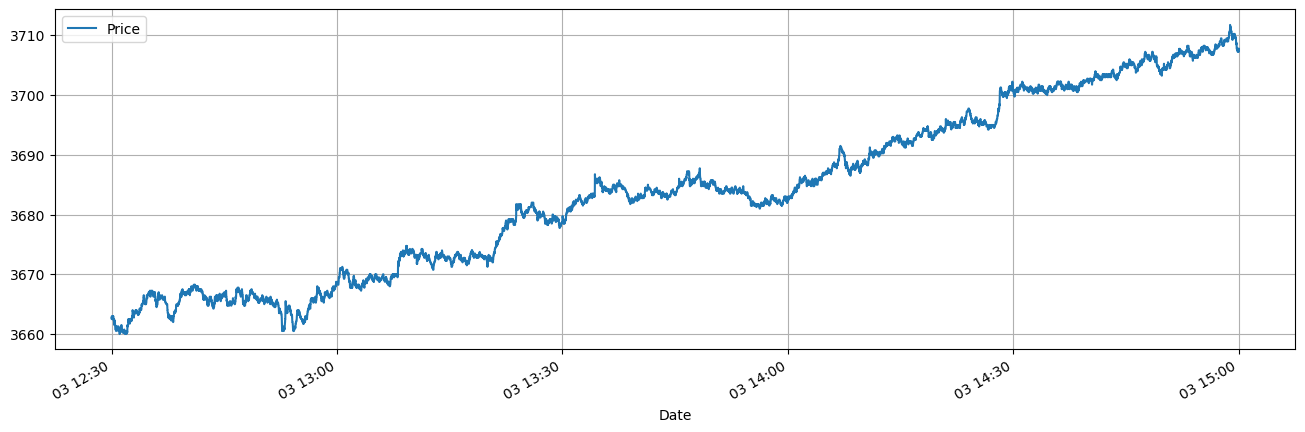

In [280]:
lr4 = dff3['2022-10-03 12:30:00': '2022-10-03 15:00:00']
lr4.plot(y = 'Price', figsize=(16,5))  
plt.grid()  
lr4.to_csv('ES2022-10-03SecLR4.csv')

### This concludes the datasets prep. 
- Conversions from tick to second-ingtervals, isolating 4 linear runs (LRs) for further analysis.
- Reductions of up to 95-98% rows from original dataset; 
- Converted to aggregated fields